In [20]:
import scipy.io
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from keras.preprocessing import image
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Flatten
from sklearn.model_selection import train_test_split
from keras.models import load_model
import matplotlib.pyplot as plt
import cv2

In [2]:
mat = scipy.io.loadmat('wiki_crop/wiki.mat')

In [3]:
instances = mat['wiki'][0][0][0].shape[1]
columns = ["dob", "photo_taken", "full_path", "gender", "name", "face_location", "face_score", "second_face_score"]

In [4]:
df = pd.DataFrame(index = range(0,instances), columns = columns)

for i in mat:
    if i == "wiki":
        current_array = mat[i][0][0]
        for j in range(len(current_array)):
            df[columns[j]] = pd.DataFrame(current_array[j][0])

In [5]:
def datenum_to_datetime(datenum):
    days = datenum % 1
    hours = days % 1 * 24
    minutes = hours % 1 * 60
    seconds = minutes % 1 * 60
    
    exact_date = datetime.fromordinal(int(datenum)) + timedelta(days=int(days)) + timedelta(hours=int(hours)) + timedelta(minutes=int(minutes)) + timedelta(seconds=round(seconds)) - timedelta(days=366)
    
    
    return exact_date.year

df['date_of_birth'] = df['dob'].apply(datenum_to_datetime)

In [6]:
df['age'] = df['photo_taken'] - df['date_of_birth']

In [7]:
#remove pictures does not include face
df = df[df['face_score'] != -np.inf]
 
#some pictures include more than one face, remove them
df = df[df['second_face_score'].isna()]
 
#check threshold
df = df[df['face_score'] >= 3]
 
#some records do not have a gender information
df = df[~df['gender'].isna()]
 
df = df.drop(columns = ['name','face_score','second_face_score','date_of_birth','face_location'])

#some guys seem to be greater than 100. some of these are paintings. remove these old guys
df = df[df['age'] <= 100]
 
#some guys seem to be unborn in the data set
df = df[df['age'] > 0]

In [8]:
target_size = (224, 224)
def getImagePixels(image_path):
    img = image.load_img("wiki_crop/%s" % image_path[0], grayscale=False, target_size=target_size)
    x = image.img_to_array(img).reshape(1, -1)[0]
    #x = preprocess_input(x)
    return x
 
df['pixels'] = df['full_path'].apply(getImagePixels)

In [9]:
target = df['gender'].values
target_classes = keras.utils.to_categorical(target, 2)

In [10]:
#features = df['pixels'].values
features = []

for i in range(0, df.shape[0]):
    features.append(df['pixels'].values[i])

features = np.array(features)
features = features.reshape(features.shape[0], 224, 224, 3)
features.shape

(22138, 224, 224, 3)

In [11]:
features /= 255 #normalize in [0, 1]

In [12]:
x_train, x_valid, y_train, y_valid = train_test_split(features, target_classes, test_size=0.10)

In [13]:
vgg16_model = keras.applications.vgg16.VGG16()

model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)
    
for layer in model.layers:
    layer.trainable = False
    
model.add(Dense(2, activation='softmax'))

In [14]:
model.load_weights('gender_wiki_new_weights.h5')

In [15]:
def loadImage(filepath):
    test_img = image.load_img(filepath, target_size=(224, 224))
    test_img = image.img_to_array(test_img)
    test_img = np.expand_dims(test_img, axis = 0)
    test_img /= 255
    return test_img

In [23]:
def test_imgs(file_name):

    prediction = model.predict(loadImage(file_name))

    img = image.load_img(file_name)#, target_size=(224, 224))
    plt.imshow(img)
    plt.show()

    gender = "Male" if np.argmax(prediction) == 1 else "Female"

    print("gender: ", gender)

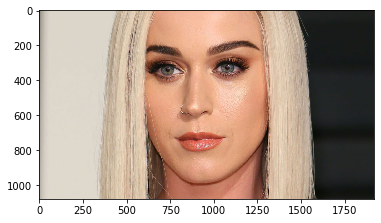

gender:  Female


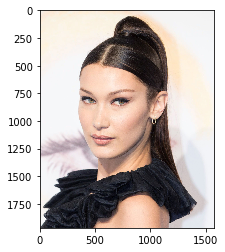

gender:  Female


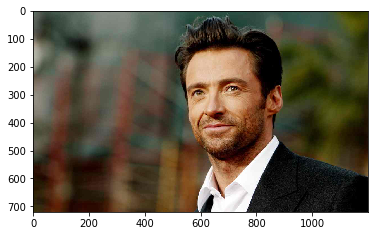

gender:  Male


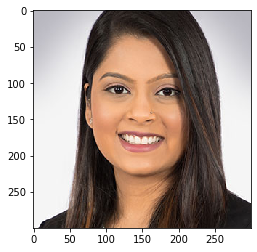

gender:  Female


In [24]:
for i in range(4):
    s = './test/' + str(i+1) + '.jpg'
    test_imgs(s)

In [26]:
# For face detection

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

cap = cv2.VideoCapture(0)

while(cap.isOpened()):
    ret, img = cap.read()

    faces = face_cascade.detectMultiScale(img, 1.3, 5)
    for (x,y,w,h) in faces:
        if w > 130:
            cv2.rectangle(img,(x,y), (x+w, y+h), (128,128,1))

            # extracted detected face
            detected_face = img[int(y):int(y+h), int(x):int(x+w)] #crop detected face


            try:
                #gender data set has 40% margin around the face. expand detected face.
                margin = 30
                margin_x = int((w*margin)/100); margin_y = int((h*margin)/100)
                detected_face = img[int(y-margin_y):int(y+h+margin_y), int(x-margin_x):int(x+w+margin_x)]

            except:
                print("Detected face has no margin")

            try:
                detected_face = cv2.resize(detected_face, (224, 224))

                img_pixels = image.img_to_array(detected_face)
                img_pixels = np.expand_dims(img_pixels, axis = 0)
                img_pixels /= 255

                #find out age and gender
                gender_distribution = model.predict(img_pixels)[0]
                gender_index = np.argmax(gender_distribution)

                if gender_index == 0: 
                    gender = "Female"
                else:
                    gender = "Male"

                #background for age gender declaration
                info_box_color = (46,200,255)
                triangle_cnt = np.array( [(x+int(w/2), y), (x+int(w/2)-20, y-20), (x+int(w/2)+20, y-20)] )
                cv2.drawContours(img, [triangle_cnt], 0, info_box_color, -1)
                cv2.rectangle(img,(x+int(w/2)-50,y-20),(x+int(w/2)+50,y-90),info_box_color,cv2.FILLED)

                cv2.putText(img, gender, (x+int(w/2)-42, y - 45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 111, 255), 2)

            except Exception as e:
                pass
    cv2.imshow('Window', img)

    if cv2.waitKey(1) & 0xFF == 27:
        break

cap.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 